In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import os
import random
import gc

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)

In [3]:
# Define the Attention Layer
class Attention(nn.Module):
    def __init__(self, shape):
        super(Attention, self).__init__()
        self.attention_dense = nn.Linear(shape, shape)
    
    def forward(self, inputs):
        n_steps = inputs.size(1)
        a = self.attention_dense(inputs)
        a = F.softmax(a, dim=-1)
        output_attention_mul = inputs * a
        return output_attention_mul

# Define the Model
class CustomModel(nn.Module):
    def __init__(self, n_wind, n_features, dense_nparams1=128):
        super(CustomModel, self).__init__()
        self.attention = Attention(n_features)
        self.lstm = nn.LSTM(n_features, dense_nparams1, num_layers=1, batch_first=True)
        self.dense = nn.Linear(dense_nparams1, 1)
    
    def forward(self, x):
        x = self.attention(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Extract the last output of the LSTM
        x = torch.sigmoid(self.dense(x))
        return x

In [4]:
# Define the Attention Layer
class Attention(nn.Module):
    def __init__(self, shape):
        super(Attention, self).__init__()
        self.attention_dense = nn.Linear(shape, shape)
    
    def forward(self, inputs):
        # Apply linear transformation
        a = self.attention_dense(inputs)
        # Apply softmax to get attention scores
        attention_scores = F.softmax(a, dim=-1)
        # Element-wise multiplication with inputs
        output_attention_mul = inputs * attention_scores
        return output_attention_mul, attention_scores

# Define the Model
class CustomModel_attext(nn.Module):
    def __init__(self, n_wind, n_features, dense_nparams1=128):
        super(CustomModel_attext, self).__init__()
        self.attention = Attention(n_features)
        self.lstm = nn.LSTM(n_features, dense_nparams1, num_layers=1, batch_first=True)
        self.dense = nn.Linear(dense_nparams1, 1)
    
    def forward(self, x, return_attention=False):
        # Get the attended output and attention scores
        x, attention_scores = self.attention(x)
        # Pass through LSTM
        x, _ = self.lstm(x)
        # Extract the last output of the LSTM
        x = x[:, -1, :]
        # Apply the dense layer with sigmoid activation
        x = torch.sigmoid(self.dense(x))
        
        if return_attention:
            return x, attention_scores
        return x

## load test data

In [5]:
dtest = torch.load('Mortality/Mtest.pt')
ytest = torch.load('Mortality/y_test.pt')

In [6]:
dtest.shape, ytest.shape

(torch.Size([2231, 288, 231]), torch.Size([2231]))

In [7]:
adverse_indices = torch.where(ytest == 1)[0]

In [8]:
adverse_indices, adverse_indices.shape

(tensor([   7,   24,   25,   60,   72,   73,   86,   98,  107,  110,  122,  146,
          159,  164,  180,  197,  206,  207,  209,  220,  229,  231,  248,  255,
          269,  296,  303,  325,  368,  382,  387,  399,  427,  455,  465,  468,
          504,  515,  533,  565,  579,  584,  593,  611,  616,  637,  640,  655,
          670,  671,  678,  689,  705,  712,  724,  730,  736,  755,  758,  771,
          773,  778,  792,  823,  829,  838,  851,  870,  874,  876,  878,  895,
          896,  926,  942,  948,  961,  994, 1010, 1030, 1055, 1060, 1074, 1093,
         1099, 1117, 1131, 1143, 1160, 1165, 1179, 1191, 1195, 1203, 1208, 1213,
         1214, 1220, 1228, 1232, 1235, 1251, 1269, 1280, 1283, 1287, 1311, 1329,
         1340, 1347, 1348, 1360, 1379, 1380, 1387, 1394, 1397, 1412, 1423, 1428,
         1461, 1486, 1489, 1493, 1494, 1495, 1503, 1510, 1514, 1554, 1555, 1570,
         1582, 1613, 1652, 1655, 1679, 1684, 1687, 1696, 1697, 1717, 1725, 1737,
         1761, 1771, 1782, 1

In [9]:
# dtest1394 = dtest.numpy()[1394]
dtest1394 = dtest.numpy()[1394]

In [10]:
# model = CustomModel(288, 231)
model = CustomModel_attext(288, 231)

## load weights

In [11]:
modeldir = sorted(os.listdir('model_checkpoints/mortality/models'))

In [12]:
len(modeldir)

1000

In [13]:
288*231

66528

### how to do this loop

In [14]:
pred_list = []
topall_list = []

for i in tqdm(range(0,1000)):
    modelfile = modeldir[i]
    # model = CustomModel(288, 231)
    model = CustomModel_attext(288,231)
    model.load_state_dict(torch.load(f'model_checkpoints/mortality/models/{modelfile}'))
    model.eval()  # Set the model to evaluation mode
    model = model.cuda(0)
    dtest7_tensor = torch.tensor(dtest1394).unsqueeze(0).cuda(0)
    with torch.no_grad():
        pred7, attention_scores = model(dtest7_tensor, return_attention=True)
        pred7 = pred7.item()
        att_scores = attention_scores.squeeze().detach().cpu().numpy()
        
        
    # print(att_scores.shape)
    flattened = att_scores.flatten()
    ranks = np.argsort(np.argsort(-flattened)) + 1
    att_ranks = ranks.reshape(att_scores.shape)
    topall_list.append(att_ranks)
        
#     pred_list.append(round(pred7,4))
#     #---------------------------------------------------------------------- old code
#     # pred7 = model(torch.tensor(dtest7).unsqueeze(0).cuda(0)).item()
#     # pred_list.append(round(pred7,4))
#     # # Extract the weight matrix from the attention_dense layer
#     # weight_matrix = model.attention.attention_dense.weight.data
#     # wmnp = weight_matrix.detach().cpu().numpy()
#     # input_after_att = np.dot(dtest7,wmnp)
#     # att_scores = F.softmax(torch.tensor(input_after_att), dim=1)
#     #----------------------------------------------------------------------- old code
    
    # Define the number of top values to highlight
#     num_top_values = 66528 #500

#     # Find the indices of the top N values
#     flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
#     top_indices = np.unravel_index(flat_indices, att_scores.T.shape)
    
#     topall_list.append(top_indices)

    
    
    # fig, ax = plt.subplots(1, 1, figsize=(16, 1))
    # im = plt.imshow(att_ranks.T, cmap='Reds_r', aspect='auto', interpolation='nearest')
    # plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {round(pred7,4)}')
    # plt.xlabel("Time Points")
    # plt.ylabel("Features")
    # ax.spines['right'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # fig.colorbar(im, ax=ax, 
    #              location = 'right',
    #              orientation='vertical',
    #              # fraction=0.9,
    #              # aspect=2,
    #              pad=0.01,
    #              # bbox_to_anchor=(0.1,0,1,1),
    #              # shrink=0.5,
    #              # anchor=(0.5, 0.5)
    #             )
    # # plt.scatter(top_indices[1], top_indices[0], color='r', marker='.', s=20, label='Top Values',alpha=0.5)
    # # ax.legend(bbox_to_anchor=(1.125, 1.02))
    # plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
len(topall_list)

1000

In [16]:
att_rank_array = np.stack(topall_list)

In [17]:
att_rank_array.shape

(1000, 288, 231)

In [70]:
# att_rank_array.shape = (1000, 288, 231)
num_models, num_timesteps, num_features = att_rank_array.shape

# Initialize an array to store cumulative variances
# shape = (num_models, num_timesteps, num_features)
cumulative_variance = np.zeros((num_models, num_timesteps, num_features))

# Compute cumulative variance clearly and efficiently
for i in tqdm(range(num_models)):
    # Consider ranks up to the current model (0 to i inclusive)
    current_data = att_rank_array[:i+1, :, :]  # shape: (i+1, 288, 231)
    
    # Calculate variance along the model dimension (axis=0)
    # variance_at_step = np.var(current_data, axis=0)
    variance_at_step = np.std(current_data, axis=0) ## I know the variable name is var but just to calculate stdev 
    
    # Store the calculated variance at this cumulative step
    cumulative_variance[i, :, :] = variance_at_step

  0%|          | 0/1000 [00:00<?, ?it/s]

In [71]:
cumulative_variance.shape

(1000, 288, 231)

In [72]:
np.max(cumulative_variance[-100])

28564.206278344074

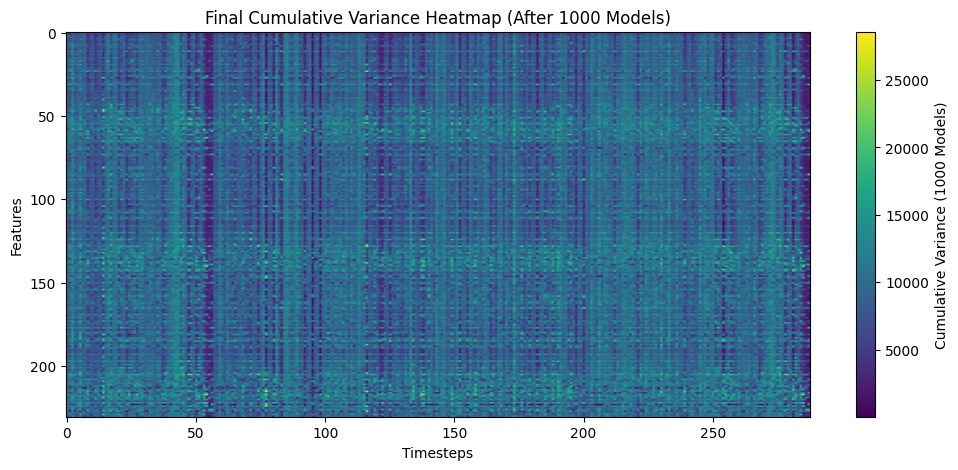

In [73]:
plt.figure(figsize=(12, 5))
plt.imshow(cumulative_variance[-1, :, :].T, aspect='auto', cmap='viridis')
plt.colorbar(label='Cumulative Variance (1000 Models)')
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.title('Final Cumulative Variance Heatmap (After 1000 Models)')
plt.show()

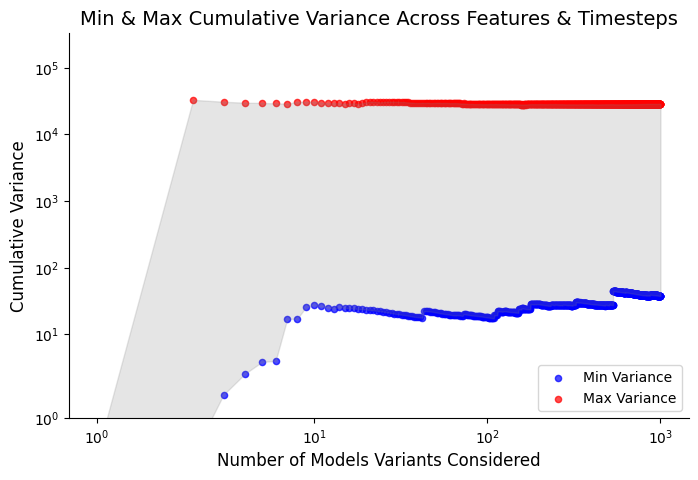

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate cumulative variance array (replace this with actual computation)
num_models = 1000
num_timesteps = 288
num_features = 231

# Example: Generate synthetic cumulative variance data for demonstration
np.random.seed(42)
# cumulative_variance = np.cumsum(np.random.rand(num_models, num_timesteps, num_features) * 0.001, axis=0)

# Define model intervals at which to compute min/max variance
model_intervals = np.linspace(1, num_models, 1000, dtype=int)  # 10 evenly spaced intervals

# Store min and max variance at each interval
min_variance = []
max_variance = []

for model_idx in model_intervals:
    variance_at_step = cumulative_variance[model_idx - 1, :, :]  # Get variance for this model count
    min_variance.append(np.min(variance_at_step))  # Min across all timesteps & features
    max_variance.append(np.max(variance_at_step))  # Max across all timesteps & features

# Convert to arrays for plotting
min_variance = np.array(min_variance)
max_variance = np.array(max_variance)

# Create clean plot with log scale
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(model_intervals, min_variance, label='Min Variance', color='blue', s=20, alpha=0.7,
           # linestyle='--', 
           marker='o')
ax.scatter(model_intervals, max_variance, label='Max Variance', color='red', s=20, alpha=0.7,
           # linestyle='-', 
           marker='o')
ax.fill_between(model_intervals, min_variance, max_variance, color='gray', alpha=0.2)  # Shaded region

# Set log scale for x-axis
ax.set_xscale('symlog')
ax.set_yscale('symlog')

ax.set_ylim(1, np.max(cumulative_variance)*10)
# Labels and title
ax.set_xlabel('Number of Models Variants Considered', fontsize=12)
ax.set_ylabel('Cumulative Variance', fontsize=12)
ax.set_title('Min & Max Cumulative Variance Across Features & Timesteps', fontsize=14)

# Remove top and right borders for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend and grid
ax.legend(loc='lower right')
# ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()
# plt.savefig('Rank_variance.png', dpi=500, bbox_inches='tight')


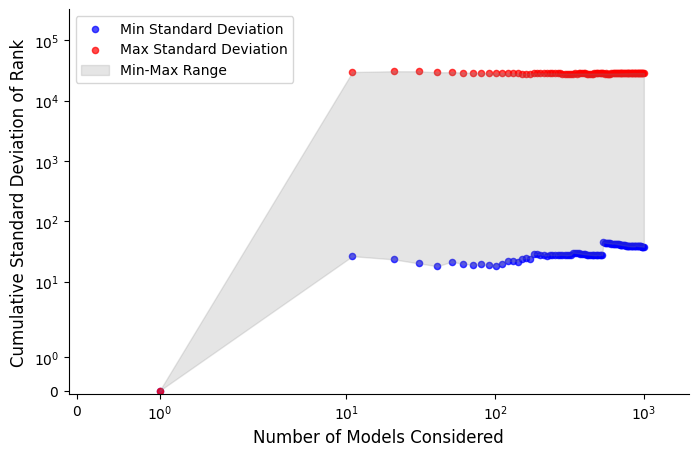

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate cumulative variance array (replace with actual computation if available)
num_models = 1000
num_timesteps = 288
num_features = 231

# Example: Generate synthetic cumulative variance data for demonstration
np.random.seed(42)
# cumulative_variance = np.cumsum(np.random.rand(num_models, num_timesteps, num_features) * 0.001, axis=0)

# Define model intervals at which to compute min/max variance
model_intervals = np.linspace(1, num_models, 100, dtype=int)  # 10 evenly spaced intervals

# Store min, max, mean, and std variance at each interval
min_variance = []
max_variance = []
mean_variance = []
std_variance = []

for model_idx in model_intervals:
    variance_at_step = cumulative_variance[model_idx - 1, :, :]  # Get variance for this model count
    min_variance.append(np.min(variance_at_step))  # Min across all timesteps & features
    max_variance.append(np.max(variance_at_step))  # Max across all timesteps & features
    mean_variance.append(np.mean(variance_at_step))  # Mean across all timesteps & features
    std_variance.append(np.std(variance_at_step))  # Standard deviation across all timesteps & features

# Convert to arrays for plotting
min_variance = np.array(min_variance)
max_variance = np.array(max_variance)
mean_variance = np.array(mean_variance)
std_variance = np.array(std_variance)

# Create clean plot with log scale including min, max, mean, and standard deviation
fig, ax = plt.subplots(figsize=(8, 5))

# Plot min and max variance
# ax.plot(model_intervals, min_variance, label='Min Variance', color='blue', linestyle='--', marker='o')
# ax.plot(model_intervals, max_variance, label='Max Variance', color='red', linestyle='-', marker='s')
ax.scatter(model_intervals, min_variance, label='Min Standard Deviation', color='blue', s=20, alpha=0.7,
           # linestyle='--', 
           marker='o')
ax.scatter(model_intervals, max_variance, label='Max Standard Deviation', color='red', s=20, alpha=0.7,
           # linestyle='-', 
           marker='o')
ax.fill_between(model_intervals, min_variance, max_variance, color='gray', alpha=0.2, label="Min-Max Range")

# # Plot mean variance with standard deviation shaded region
# ax.scatter(model_intervals, mean_variance, label='Mean Variance', color='green', s=20, alpha=0.7,
#         # linestyle='-', 
#         marker='o')

# ax.fill_between(model_intervals, mean_variance - std_variance, mean_variance + std_variance, 
#                 color='green', alpha=0.2, label="Mean ± 1 Std Dev")

# Set log scale for x-axis
ax.set_xscale('symlog')
ax.set_yscale('symlog')
# Set y-axis limits
# y_min, y_max = 0, np.max(max_variance) * 1.1  # Extend y max slightly for better visibility
# ax.set_ylim(y_min, y_max)
ax.set_ylim(-0.1, np.max(cumulative_variance)*10)
ax.set_xlim(-0.1, 2000)

# Labels and title
ax.set_xlabel('Number of Models Considered', fontsize=12)
ax.set_ylabel('Cumulative Variance', fontsize=12)
ax.set_ylabel('Cumulative Standard Deviation of Rank', fontsize=12)
# ax.set_title('Standard Deviation Evolution Across Features & Timesteps', fontsize=14)

# Remove top and right borders for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend and grid
ax.legend()
# ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Display the plot
# plt.show()
plt.savefig('Rank_stdev_v3.png', dpi=500, bbox_inches='tight')


In [83]:
def plot_heatmap(matrix, title="Heatmap", cmap="viridis", xticks_label="Time", yticks_label="Features"):
    """
    Plots a heatmap of the given matrix with labeled start and end ticks.
    """
    plt.figure(figsize=(6, 4))  # Adjusted figure size for better visibility
    plt.imshow(matrix.T, cmap=cmap, aspect='auto')
    plt.colorbar(label="Rank")
    plt.title(title)
    
    # Set labels for the axes
    plt.xlabel(xticks_label)
    plt.ylabel(yticks_label)
    
    # Add start and end ticks for both axes
    plt.yticks([0, matrix.shape[1] - 1], [0, matrix.shape[1] - 1])  # X-axis (time)
    plt.xticks([0, matrix.shape[0] - 1], [0, matrix.shape[0] - 1])  # Y-axis (features)
    
    plt.show()

In [84]:
def analyze_rank_changes(ranked_matrices):
    """
    Analyzes rank changes across multiple ranked matrices.
    Computes mean and standard deviation of ranks for each entry.
    """
    ranked_matrices = np.stack(ranked_matrices)  # Shape: (num_matrices, rows, cols)
    
    mean_ranks = np.mean(ranked_matrices, axis=0)
    std_ranks = np.std(ranked_matrices, axis=0)
    
    return mean_ranks, std_ranks

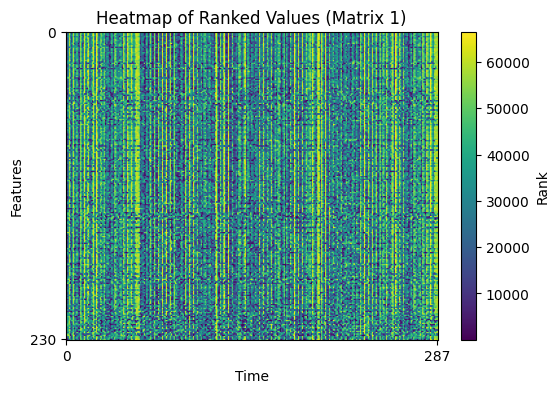

In [85]:
# Step 1: Plot heatmap for the first matrix
first_matrix = att_rank_array[0]
plot_heatmap(first_matrix, title="Heatmap of Ranked Values (Matrix 1)")

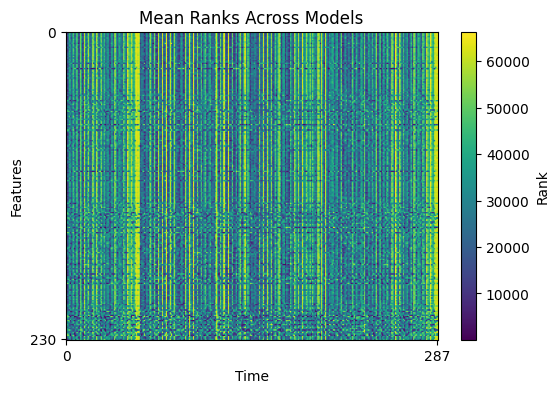

In [87]:
# Step 1: Analyze rank changes across all matrices
mean_ranks, std_ranks = analyze_rank_changes(att_rank_array)

# Step 2: Plot heatmaps for mean and standard deviation of ranks
plot_heatmap(mean_ranks, title="Mean Ranks Across Models")
# plot_heatmap(std_ranks, title="Rank Standard Deviation Across Models", cmap="coolwarm")

In [261]:
ranked_matrices=att_rank_array

In [262]:
# ranked_matrices = np.stack(ranked_matrices)
rank_variances = np.var(ranked_matrices, axis=0)

In [263]:
np.min(rank_variances), np.max(rank_variances)

(1420.246124, 816655263.1357919)

In [264]:
mean_ranks = np.mean(np.stack(ranked_matrices), axis=0)

In [265]:
np.min(mean_ranks), np.max(mean_ranks)

(19.626, 66370.386)

In [266]:
mean_ranks.shape

(288, 231)

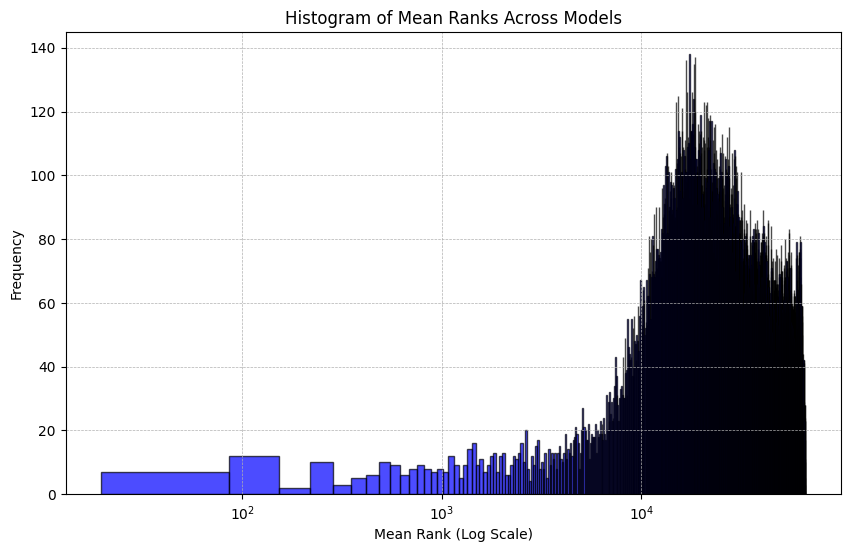

In [267]:
# Plot the histogram of mean ranks with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(mean_ranks.flatten(), bins=1000, color='blue', alpha=0.7, edgecolor='black')
plt.xscale('symlog')  # Set x-axis to logarithmic scale
# plt.yscale('log')  # Set x-axis to logarithmic scale
plt.title("Histogram of Mean Ranks Across Models")
plt.xlabel("Mean Rank (Log Scale)")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [127]:
ranked_matrices_sub = ranked_matrices[:100]

In [129]:
# # Step 1: Compute cumulative average ranks across models
# cumulative_average_ranks = np.cumsum(ranked_matrices_sub, axis=0) / np.arange(1, ranked_matrices_sub.shape[0] + 1)[:, None, None]

# # Step 2: Prepare data for 3D scatter plot
# models = np.arange(1, cumulative_average_ranks.shape[0] + 1)  # Z-axis: Models
# features = np.arange(cumulative_average_ranks.shape[1])  # X-axis: Features
# time_steps = np.arange(cumulative_average_ranks.shape[2])  # Y-axis: Time Steps
# X, Y, Z = np.meshgrid(features, time_steps, models, indexing="ij")

# # Flatten the data for plotting
# X_flat = X.flatten()
# Y_flat = Y.flatten()
# Z_flat = Z.flatten()
# cumulative_ranks_flat = cumulative_average_ranks.flatten()

# # Step 3: Create 3D scatter plot
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')

# scatter = ax.scatter(X_flat, Y_flat, Z_flat, c=cumulative_ranks_flat, cmap='viridis', alpha=0.7)

# ax.set_title("3D Scatter Plot: Cumulative Average Ranks")
# ax.set_xlabel("Feature Index")
# ax.set_ylabel("Time Step")
# ax.set_zlabel("Model Index")
# fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, label="Cumulative Average Rank")
# plt.show()

In [153]:
# cumulative_average_ranks[5]

In [268]:
# Step 1: Compute cumulative average ranks across models
from matplotlib.colors import LogNorm

cumulative_average_ranks = np.cumsum(ranked_matrices, axis=0) / np.arange(1, ranked_matrices.shape[0] + 1)[:, None, None]

In [269]:
# cumulative_average_ranks[0]

In [270]:
# cumulative_average_ranks[1]

In [271]:
# cumulative_average_ranks[2]

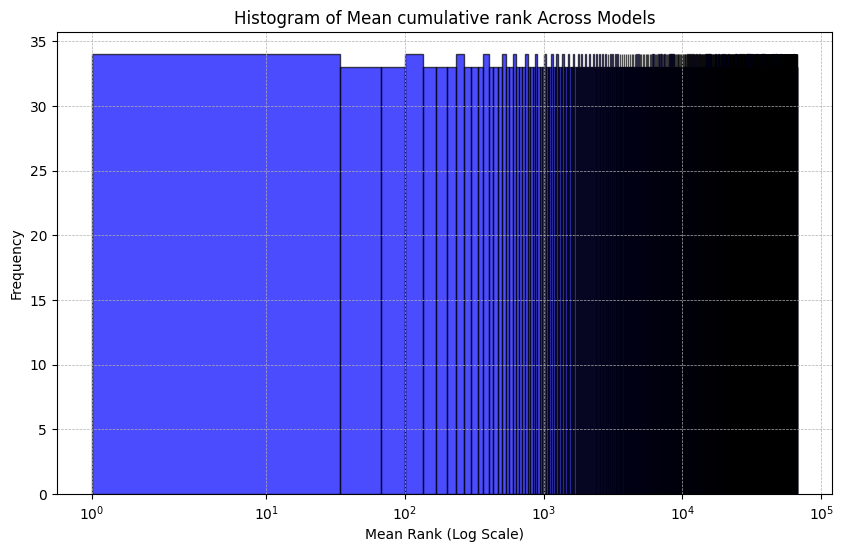

In [272]:
# Plot the histogram of mean ranks with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(cumulative_average_ranks[0].flatten(), bins=2000, color='blue', alpha=0.7, edgecolor='black')
# plt.yscale('symlog')  # Set x-axis to logarithmic scale
plt.xscale('symlog')  # Set x-axis to logarithmic scale
plt.title("Histogram of Mean cumulative rank Across Models")
plt.xlabel("Mean Rank (Log Scale)")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

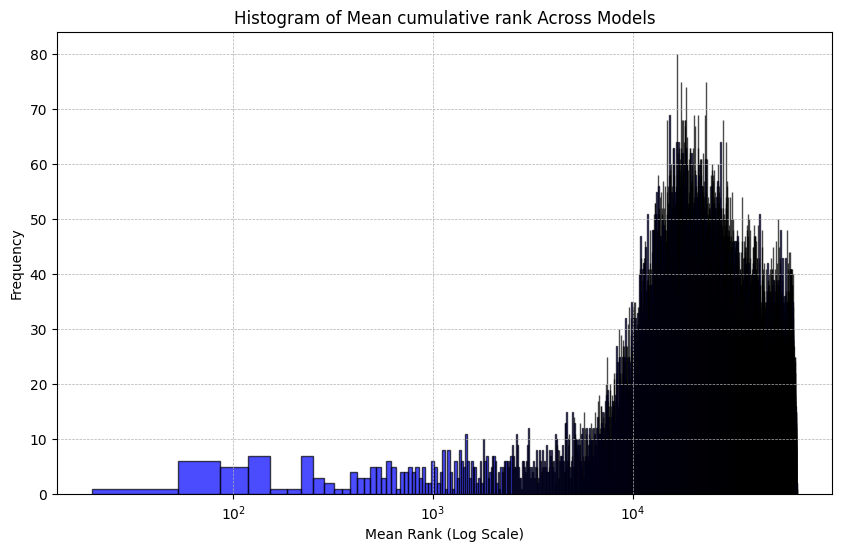

In [273]:
# Plot the histogram of mean ranks with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist(cumulative_average_ranks[-1].flatten(), bins=2000, color='blue', alpha=0.7, edgecolor='black')
# plt.yscale('symlog')  # Set x-axis to logarithmic scale
plt.xscale('symlog')  # Set x-axis to logarithmic scale
plt.title("Histogram of Mean cumulative rank Across Models")
plt.xlabel("Mean Rank (Log Scale)")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

In [274]:
# Step 1: Select 16 indices to plot (e.g., evenly spaced between 1 and 1000)
# Step 1: Select indices using powers of 2
indices = [2**i for i in range(5) if 2**i <= 1000]  # Ensure indices are within the range of 1 to 1000

In [275]:
indices = [1, 2, 4, 8, 16, 32, 128, 512, 1000]

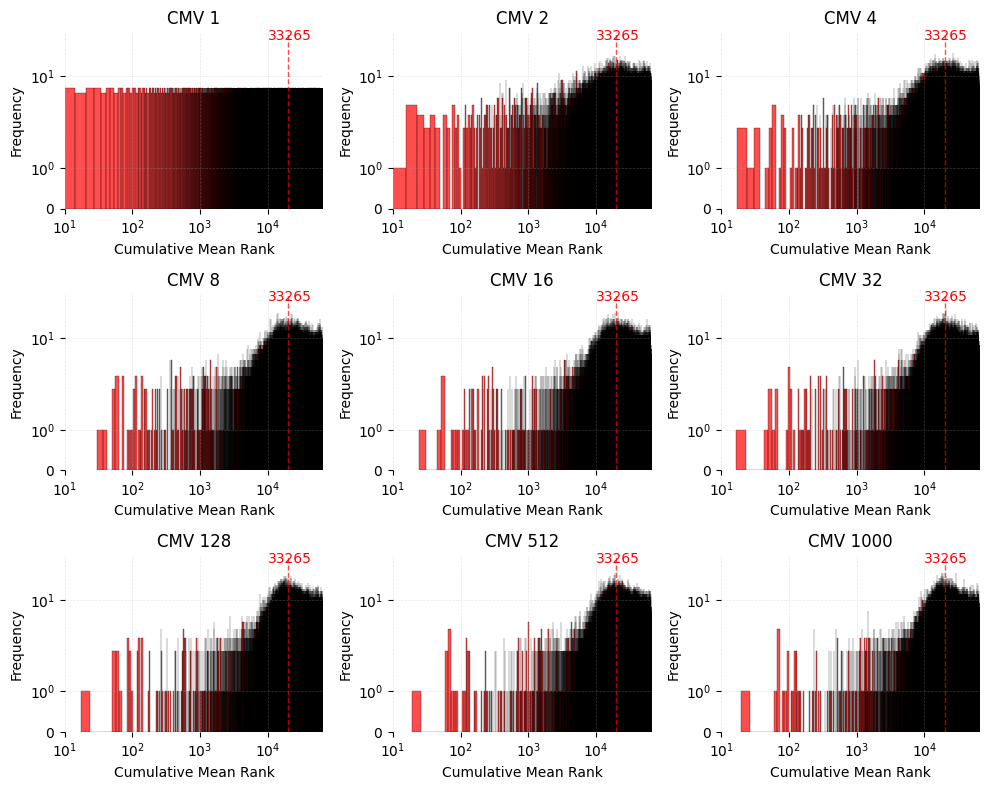

In [282]:
# Step 2: Create a 4x4 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
# fig.suptitle("Histogram of Mean Cumulative Ranks Across Models", fontsize=16)

# Step 3: Plot each histogram
for ax, idx in zip(axes.flatten(), indices):
    data = cumulative_average_ranks[idx - 1].flatten()  # Flatten the matrix for the selected model
    ax.hist(data, bins=10000, color='red', alpha=0.7, edgecolor='black',linewidth=0.3)
    ax.set_xscale('symlog')  # Log scale for x-axis
    ax.set_yscale('symlog')  # Log scale for y-axis
    ax.set_title(f"CMV {idx}", fontsize=12)
    ax.set_xlim(10, 66528)  # Set consistent x-axis limits
    ax.set_ylim(0, 40)  # Set consistent y-axis limits
    # ax.set_xlabel("Mean Rank (Log Scale)")
    # ax.set_ylabel("Frequency (Log Scale)")
    ax.set_xlabel("Cumulative Mean Rank")
    ax.set_ylabel("Frequency")
    ax.grid(True, which="both", linestyle='--', linewidth=0.5,alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(x=33265, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.text(10000, ax.get_ylim()[1] * 0.9, "33265", color='red', fontsize=10, rotation=0, va='center')

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 1])
# plt.show()
plt.savefig('Figure04_rank_analysis.png', dpi=400, bbox_inches='tight')

In [283]:
!pwd

/home/shashank/data/VAHC_2024


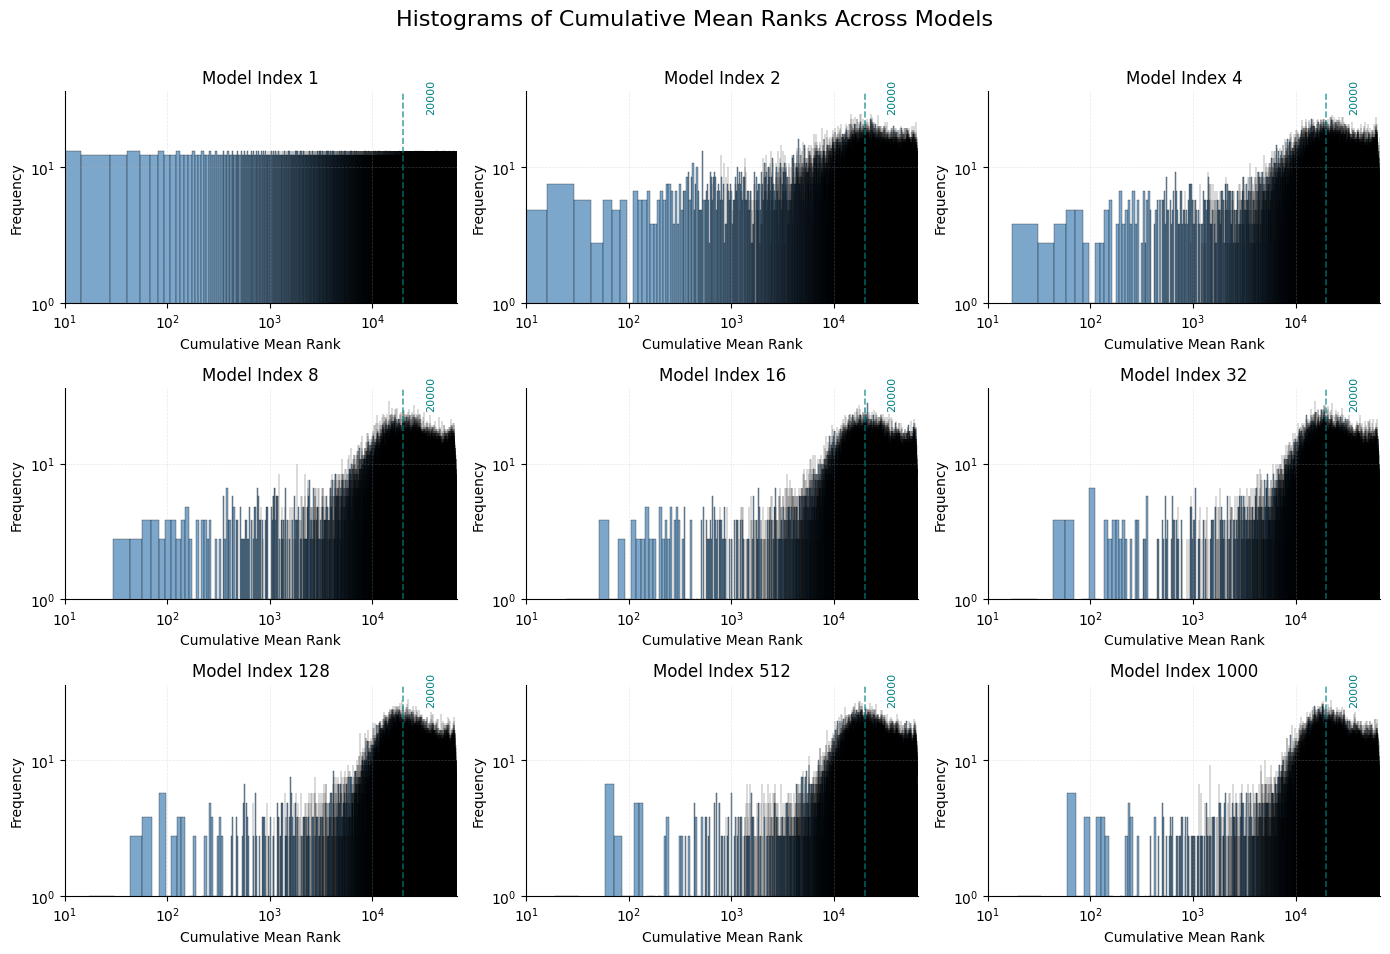

In [221]:
# # Step 2: Create a 3x3 grid of subplots
# fig, axes = plt.subplots(3, 3, figsize=(14, 10))
# fig.suptitle("Histograms of Cumulative Mean Ranks Across Models", fontsize=16, y=0.95)

# # Step 3: Plot each histogram
# for ax, idx in zip(axes.flatten(), indices):
#     data = cumulative_average_ranks[idx - 1].flatten()  # Flatten the matrix for the selected model
    
#     # Plot histogram
#     ax.hist(data, bins=5000, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.3)
    
#     # Log scales for both axes
#     ax.set_xscale('symlog')
#     ax.set_yscale('symlog')
    
#     # Set consistent axis limits
#     ax.set_xlim(10, 66528)
#     ax.set_ylim(1, 50)
    
#     # Add subplot title
#     ax.set_title(f"Model Index {idx}", fontsize=12)
    
#     # Set axis labels
#     ax.set_xlabel("Cumulative Mean Rank", fontsize=10)
#     ax.set_ylabel("Frequency", fontsize=10)
    
#     # Add a vertical line at x = 20000
#     ax.axvline(x=20000, color='teal', linestyle='--', linewidth=1.2, alpha=0.7)
#     ax.text(33264, ax.get_ylim()[1] * 0.9, "20000", color='teal', fontsize=8, rotation=90, va='center')
    
#     # Style grid and spines
#     ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.3)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# # Handle layout and spacing
# plt.tight_layout(rect=[0, 0, 1, 0.94])
# plt.show()

In [184]:
cumulative_average_ranks[-1].shape

(288, 231)

In [181]:
# Plot the histogram of mean ranks with a logarithmic x-axis
plt.figure(figsize=(10, 6))
plt.hist2d(, bins=10000, color='blue', alpha=0.7, edgecolor='black')
plt.yscale('symlog')  # Set x-axis to logarithmic scale
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.title("Histogram of Mean cumulative rank Across Models")
plt.xlabel("Mean Rank (Log Scale)")
plt.ylabel("Frequency")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()

TypeError: hist2d() missing 1 required positional argument: 'y'

<Figure size 1000x600 with 0 Axes>

In [160]:
# # Step 2: Plot 2D contour maps for specific model indices
# model_indices = [1,2,3,4,5,10,100,500, 1000]  # Choose specific models to visualize


# # Create a grid layout for better visualization
# fig, axes = plt.subplots(nrows=len(model_indices), ncols=1, figsize=(12, 2 * len(model_indices)))

# for ax, model_idx in zip(axes, model_indices):
#     cumulative_ranks_at_model = cumulative_average_ranks[model_idx - 1, :, :]  # Shape: (288, 231)
    
#     contour = ax.contourf(
#         cumulative_ranks_at_model, 
#         levels=100, 
#         cmap='cividis', 
#         norm=LogNorm(vmin=cumulative_ranks_at_model.min(), vmax=cumulative_ranks_at_model.max())
#     )
#     cbar = plt.colorbar(contour, ax=ax, orientation="horizontal", pad=0.1)
#     cbar.set_label("Cumulative Rank (Log Scale)")
    
#     ax.set_title(f"Cumulative Ranks at Model {model_idx}")
#     ax.set_xlabel("Time Step")
#     ax.set_ylabel("Feature Index")

# plt.tight_layout()
# plt.show()

In [163]:
from matplotlib.colors import Normalize

In [165]:
# Step 1: Flatten cumulative_average_ranks to shape (1000, featxtime)
num_models, num_features, num_time = cumulative_average_ranks.shape
feat_time_size = num_features * num_time
flattened_ranks = cumulative_average_ranks.reshape(num_models, feat_time_size)

In [169]:
# # Step 2: Plot with progress bar
# plt.figure(figsize=(12, 8))

# for model_idx in tqdm(range(num_models), desc="Plotting Models"):
#     x = np.full(feat_time_size, model_idx + 1)
#     y = np.arange(1, feat_time_size + 1)
#     colors = flattened_ranks[model_idx, :]
#     plt.scatter(x, y, c=colors, cmap='cividis', norm=LogNorm(vmin=flattened_ranks.min(), vmax=flattened_ranks.max()), s=0.1, alpha=0.7)

# # Add colorbar and labels
# plt.colorbar(label="Rank")
# plt.title("Feature-Time Rank Trends Across Models")
# plt.xlabel("Model Number")
# # plt.xscale('log')
# # plt.yscale('log') 
# plt.ylabel("Feature-Time Index")
# plt.grid(False)
# # plt.show()
# plt.savefig('temp_figure_ranks.png', dpi=300)

In [231]:
running_means = []
running_sum = 0

# Calculate running mean for each value in the values list
for i, value in enumerate(pred_list):
    running_sum += value
    running_mean = running_sum / (i + 1)
    running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places

# Print the results
print("Values:", pred_list)
print("Running Means:", running_means)

Values: [0.8168, 0.7181, 0.7063, 0.6433, 0.6532, 0.7458, 0.5715, 0.6235, 0.583, 0.6625, 0.6694, 0.6358, 0.6528, 0.6386, 0.6181, 0.6039, 0.6309, 0.6812, 0.748, 0.5146, 0.6941, 0.7282, 0.6591, 0.5893, 0.5204, 0.6316, 0.6418, 0.644, 0.6358, 0.6718, 0.6525, 0.6471, 0.6378, 0.6454, 0.6759, 0.6471, 0.5686, 0.64, 0.6383, 0.7145, 0.7527, 0.6633, 0.5991, 0.6404, 0.6436, 0.5774, 0.6756, 0.5953, 0.6901, 0.6432, 0.6816, 0.7181, 0.5985, 0.7895, 0.6789, 0.6074, 0.7254, 0.6676, 0.7321, 0.6786, 0.5982, 0.6613, 0.7443, 0.638, 0.7176, 0.6292, 0.8174, 0.6612, 0.6452, 0.732, 0.6397, 0.6733, 0.6934, 0.6987, 0.588, 0.6595, 0.5998, 0.6153, 0.6535, 0.6654, 0.656, 0.7118, 0.6509, 0.631, 0.6524, 0.5982, 0.6784, 0.6223, 0.7146, 0.6333, 0.6556, 0.6103, 0.6794, 0.6066, 0.6173, 0.6788, 0.6907, 0.6914, 0.6493, 0.6788, 0.6676, 0.6199, 0.6301, 0.6055, 0.6553, 0.8045, 0.6283, 0.6697, 0.6915, 0.6783, 0.6696, 0.6254, 0.6736, 0.6263, 0.6967, 0.6186, 0.6273, 0.6146, 0.7606, 0.6824, 0.6522, 0.6064, 0.7101, 0.6168, 0.8339, 0

In [40]:
# top_indices

In [53]:
# top500_list

In [97]:
# # Initialize a 2D matrix with zeros
# matrix = np.zeros((231, 288), dtype=int)

# # Fill the matrix with 1s at the positions specified by the coordinates
# for y, x in zip(top_indices[0], top_indices[1]):
#     matrix[y, x] = 1

# # Display the resulting matrix
# print(matrix.shape)

In [98]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 3))

# im = plt.imshow(matrix, cmap='binary', aspect='auto', interpolation='nearest')
# plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {round(pred7,4)}')
# plt.xlabel("Time Points")
# plt.ylabel("Features")
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# fig.colorbar(im, ax=ax, 
#              location = 'right',
#              orientation='vertical',
#              # fraction=0.9,
#              # aspect=2,
#              pad=0.01,
#              # bbox_to_anchor=(0.1,0,1,1),
#              shrink=0.3,
#              # anchor=(0.5, 0.5)
#             )
# plt.scatter(top_indices[1], top_indices[0], color='r', marker='.', s=20, label='Top Values',alpha=0.5)
# # ax.legend(bbox_to_anchor=(1.125, 1.02))
# plt.show()

## cumulative drop in top features

In [227]:
# Initialize a cumulative matrix with ones (will be used for logical AND)
cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
cl_list_10000 = []
# Iterate through each set of top_indices tuples (10 runs)
for i, top_indices in enumerate(top500_list):
    # Initialize a 2D matrix with zeros for the current run
    matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size
    
    # Fill the matrix with 1s at the positions specified by the coordinates
    for y, x in zip(top_indices[0], top_indices[1]):
        matrix[y, x] = 1
    
    # Print the shape of the matrix for the current run
    # print(f"Run {i+1} - Matrix shape: {matrix.shape}")
    
    # print(f'{i} matrix sum', np.sum(matrix))
    
    # Perform an element-wise logical AND with the cumulative matrix
    cumulative_matrix = np.logical_and(cumulative_matrix, matrix)
    
    # print(f'{i} cumulative matrix sum', np.sum(cumulative_matrix))
    
    cl_list_10000.append(np.sum(cumulative_matrix))
    
#     fig, ax = plt.subplots(1, 1, figsize=(16, 3))

#     im = plt.imshow(cumulative_matrix, cmap='binary', aspect='auto', interpolation='nearest')
#     plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {round(pred_list[i],4)}')
#     plt.xlabel("Time Points")
#     plt.ylabel("Features")
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     fig.colorbar(im, ax=ax, 
#                  location = 'right',
#                  orientation='vertical',
#                  # fraction=0.9,
#                  # aspect=2,
#                  pad=0.01,
#                  # bbox_to_anchor=(0.1,0,1,1),
#                  shrink=0.3,
#                  # anchor=(0.5, 0.5)
#                 )
#     # plt.scatter(top_indices[1], top_indices[0], color='r', marker='.', s=20, label='Top Values',alpha=0.5)
#     # ax.legend(bbox_to_anchor=(1.125, 1.02))
#     plt.show()

In [208]:
# cl_list

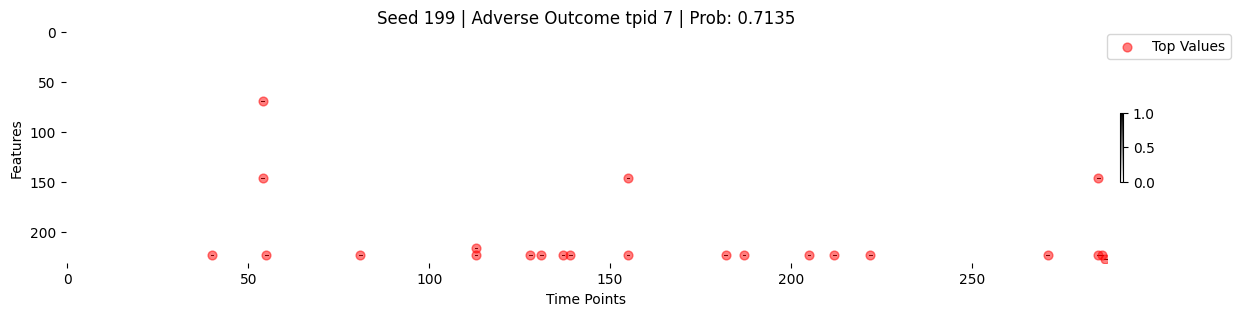

In [209]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

im = plt.imshow(cumulative_matrix, cmap='binary', aspect='auto', interpolation='nearest')
plt.title(f'Seed {i} | Adverse Outcome tpid 7 | Prob: {round(pred_list[i],4)}')
plt.xlabel("Time Points")
plt.ylabel("Features")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.colorbar(im, ax=ax, 
             location = 'right',
             orientation='vertical',
             # fraction=0.9,
             # aspect=2,
             pad=0.01,
             # bbox_to_anchor=(0.1,0,1,1),
             shrink=0.3,
             # anchor=(0.5, 0.5)
            )

## Get the indices where the value in the matrix is 1
y_indices, x_indices = np.where(cumulative_matrix == 1)

# Convert the indices to a tuple
coordinates_tuple = (y_indices.tolist(), x_indices.tolist())

plt.scatter(coordinates_tuple[1], coordinates_tuple[0], color='r', marker='o', s=40, label='Top Values',alpha=0.5)
ax.legend(bbox_to_anchor=(1.125, 1.02))
plt.show()

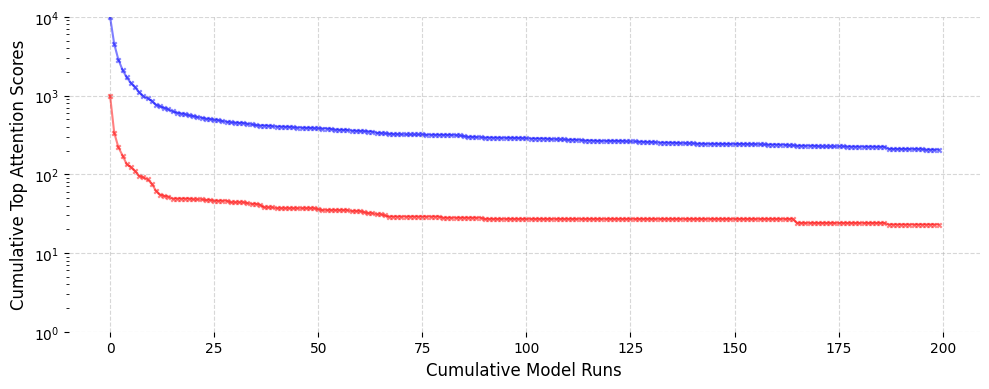

In [229]:
# Example list of 100 numbers (Replace this with your actual list)
numbers1000 = cl_list

# Create a list of indices for the x-axis
indices1000 = list(range(len(numbers1000)))

numbers10000 = cl_list_10000
indices10000 = list(range(len(numbers10000)))

# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(10, 4)) # Set figure size for better clarity

# Scatter plot with custom marker size, edge color, and transparency (alpha)
plt.scatter(indices1000, numbers1000, color='r', marker='x', s=10, alpha=0.5)
plt.plot(indices1000, numbers1000, color='r', alpha=0.5)

# Scatter plot with custom marker size, edge color, and transparency (alpha)
plt.scatter(indices10000, numbers10000, color='b', marker='x', s=10, alpha=0.5)
plt.plot(indices10000, numbers10000, color='b', alpha=0.5)

# Add a color bar to give context to the color mapping
# plt.colorbar(label='Value Intensity')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Cumulative Top Attention Scores', fontsize=12)
# plt.title('Scatter Plot of List Values', fontsize=15, weight='bold')

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('log')
plt.ylim(1,10001)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

In [130]:
invert_cm = ~cumulative_matrix
invert_bin= invert_cm.astype(int).T

In [131]:
invert_bin.shape

(288, 231)

In [132]:
np.sum(invert_bin), np.sum(cumulative_matrix), 288*231

(66498, 30, 66528)

In [133]:
xperm = invert_bin*dtest7
xperm = xperm.astype(np.float32)

In [134]:
dtest7.dtype, xperm.dtype

(dtype('float32'), dtype('float32'))

### now the top 30 are 0, when 1000 top scores were selected

In [135]:
dtest7_pert = xperm

In [136]:
pred_list = []
top500_list = []

for i in tqdm(range(100)):
    modelfile = modeldir[i]
    model = CustomModel(288, 231)
    model.load_state_dict(torch.load(f'model_checkpoints/mortality/models/{modelfile}'))
    model.eval()  # Set the model to evaluation mode
    model = model.cuda(0)
    pred7_pert = model(torch.tensor(dtest7_pert).unsqueeze(0).cuda(0)).item()
    
    pred_list.append(round(pred7_pert,4))

    # Extract the weight matrix from the attention_dense layer
    weight_matrix = model.attention.attention_dense.weight.data
    wmnp = weight_matrix.detach().cpu().numpy()
    
    input_after_att = np.dot(dtest7,wmnp)
    att_scores = F.softmax(torch.tensor(input_after_att), dim=1)
    
    # Define the number of top values to highlight
    num_top_values = 1000 #500

    # Find the indices of the top N values
    flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
    top_indices = np.unravel_index(flat_indices, att_scores.T.shape)
    
    top500_list.append(top_indices)

  0%|          | 0/100 [00:00<?, ?it/s]

In [137]:
running_means = []
running_sum = 0

# Calculate running mean for each value in the values list
for i, value in enumerate(pred_list):
    running_sum += value
    running_mean = running_sum / (i + 1)
    running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places

# Print the results
print("Values:", pred_list)
print("Running Means:", running_means)

Values: [0.779, 0.4822, 0.4192, 0.5141, 0.4321, 0.4752, 0.445, 0.4785, 0.4683, 0.3885, 0.4374, 0.621, 0.2409, 0.5488, 0.4416, 0.4148, 0.479, 0.5638, 0.3893, 0.3063, 0.4985, 0.647, 0.4171, 0.4867, 0.4037, 0.4793, 0.3589, 0.5006, 0.4074, 0.3994, 0.3611, 0.5352, 0.3537, 0.4771, 0.6269, 0.3898, 0.1291, 0.4109, 0.4719, 0.6436, 0.576, 0.4602, 0.4929, 0.5698, 0.4257, 0.516, 0.3995, 0.3321, 0.5003, 0.455, 0.4664, 0.6046, 0.3372, 0.5522, 0.5278, 0.4067, 0.5953, 0.4602, 0.5835, 0.3129, 0.3076, 0.367, 0.2597, 0.5808, 0.3702, 0.3174, 0.622, 0.5233, 0.4438, 0.6673, 0.4043, 0.5154, 0.4953, 0.5178, 0.4027, 0.4037, 0.4445, 0.2677, 0.4893, 0.4571, 0.3237, 0.4637, 0.305, 0.497, 0.4052, 0.4347, 0.5306, 0.4656, 0.4686, 0.3905, 0.389, 0.4395, 0.3659, 0.2617, 0.5088, 0.4103, 0.6333, 0.5566, 0.437, 0.4983]
Running Means: [0.779, 0.6306, 0.5601, 0.5486, 0.5253, 0.517, 0.5067, 0.5032, 0.4993, 0.4882, 0.4836, 0.495, 0.4755, 0.4807, 0.4781, 0.4742, 0.4744, 0.4794, 0.4747, 0.4663, 0.4678, 0.4759, 0.4734, 0.4739, 

In [118]:
# Initialize a cumulative matrix with ones (will be used for logical AND)
cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
cl_list = []
# Iterate through each set of top_indices tuples (10 runs)
for i, top_indices in enumerate(top500_list):
    # Initialize a 2D matrix with zeros for the current run
    matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size
    
    # Fill the matrix with 1s at the positions specified by the coordinates
    for y, x in zip(top_indices[0], top_indices[1]):
        matrix[y, x] = 1
    
    # Print the shape of the matrix for the current run
    # print(f"Run {i+1} - Matrix shape: {matrix.shape}")
    
    # print(f'{i} matrix sum', np.sum(matrix))
    
    # Perform an element-wise logical AND with the cumulative matrix
    cumulative_matrix = np.logical_and(cumulative_matrix, matrix)
    
    # print(f'{i} cumulative matrix sum', np.sum(cumulative_matrix))
    
    cl_list.append(np.sum(cumulative_matrix))

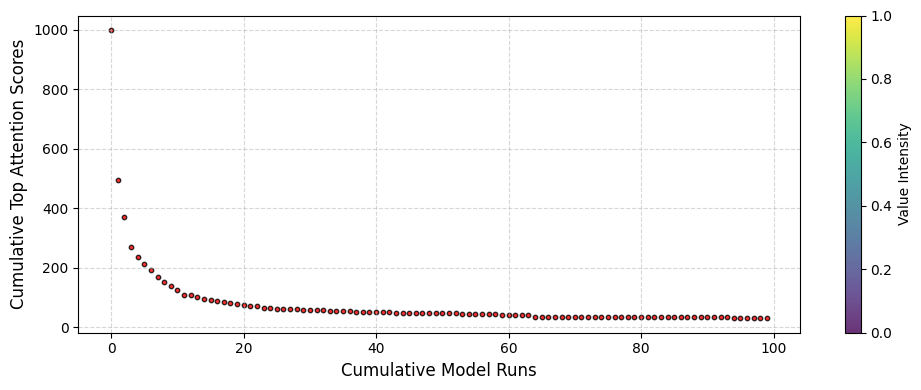

In [119]:
# Example list of 100 numbers (Replace this with your actual list)
numbers = cl_list  # Generate 100 random numbers for demonstration

# Create a list of indices for the x-axis
indices = list(range(len(numbers)))

# Create the scatter plot
plt.figure(figsize=(10, 4))  # Set figure size for better clarity

# Scatter plot with custom marker size, edge color, and transparency (alpha)
plt.scatter(indices, numbers, color='r', marker='o', edgecolor='k', s=10, alpha=0.8)

# Add a color bar to give context to the color mapping
plt.colorbar(label='Value Intensity')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Cumulative Top Attention Scores', fontsize=12)
# plt.title('Scatter Plot of List Values', fontsize=15, weight='bold')

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

In [121]:
# cl_list

In [138]:
model

CustomModel(
  (attention): Attention(
    (attention_dense): Linear(in_features=231, out_features=231, bias=True)
  )
  (lstm): LSTM(231, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=1, bias=True)
)

In [140]:
pred7 = model(torch.tensor(dtest7).unsqueeze(0).cuda(0)).item()

In [141]:
pred7

0.6788225173950195

In [147]:
weight_matrix = model.attention.attention_dense.weight.data
wmnp = weight_matrix.detach().cpu().numpy()

In [157]:
## check about it
model.attention.attention_dense.bias.shape

torch.Size([231])

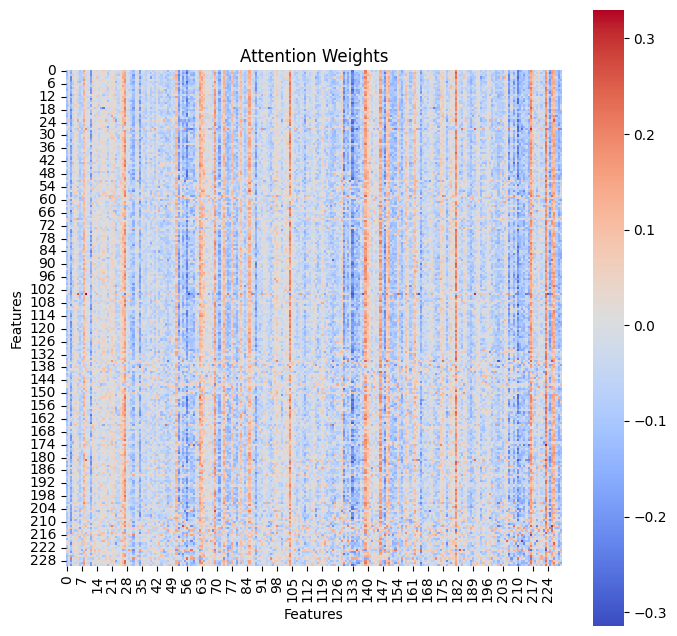

In [148]:
plt.figure(figsize=(8, 8))
sns.heatmap(wmnp, annot=False, cmap='coolwarm', cbar=True, square=True)
plt.title('Attention Weights')
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

In [146]:
# Step 2: Flatten the weight matrix, shuffle it, and reshape it back
flattened_weights = weight_matrix.flatten()  # Flatten to 1D array
shuffled_weights = flattened_weights.clone()  # Create a clone to shuffle
indices = torch.randperm(shuffled_weights.size(0))  # Generate random permutation of indices
shuffled_weights = shuffled_weights[indices]  # Apply shuffle
reshaped_weights = shuffled_weights.view(weight_matrix.shape)  # Reshape back to original shape

In [149]:
reshaped_weights.shape

torch.Size([231, 231])

In [151]:
wmnp_shuffled = reshaped_weights.detach().cpu().numpy()

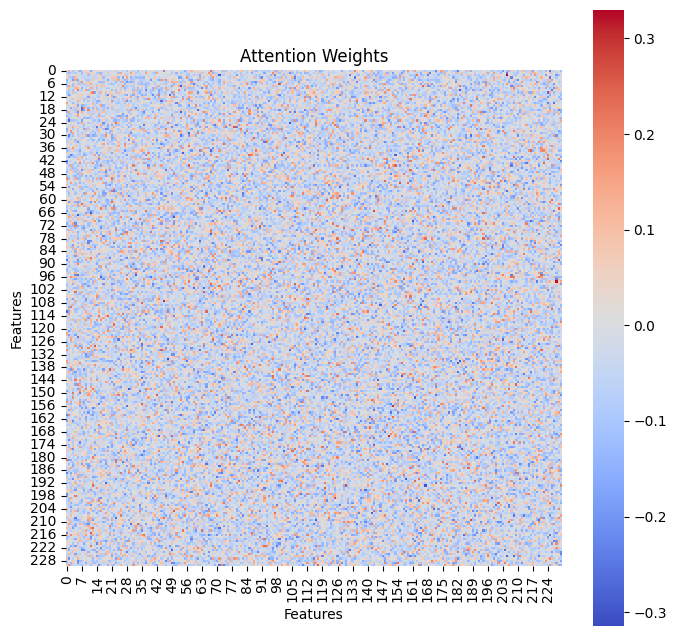

In [152]:
plt.figure(figsize=(8, 8))
sns.heatmap(wmnp_shuffled, annot=False, cmap='coolwarm', cbar=True, square=True)
plt.title('Attention Weights')
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

In [153]:
# Step 3: Reassign the shuffled weights back to the model
model.attention.attention_dense.weight.data = reshaped_weights

In [154]:
pred7 = model(torch.tensor(dtest7).unsqueeze(0).cuda(0)).item()

In [155]:
pred7

0.0347612202167511

### one function to rule them all

In [304]:
def cudrop(num_model, topk, pid):

    pred_list = []
    topk_list = []
    
    indices = list(range(num_model))

    # Shuffle the list in place
    random.shuffle(indices)
    
    for i in indices:
        modelfile = modeldir[i]
        model = CustomModel_attext(288,231)
        model.load_state_dict(torch.load(f'model_checkpoints/mortality/models/{modelfile}'))
        model.eval()  # Set the model to evaluation mode
        model = model.cuda(0)
        dtestp = dtest.numpy()[pid]
        dtestp_tensor = torch.tensor(dtestp).unsqueeze(0).cuda(0)
        with torch.no_grad():
            predp, attention_scores = model(dtestp_tensor, return_attention=True)
            predp = predp.item()
            att_scores = attention_scores.squeeze().detach().cpu().numpy()

        pred_list.append(round(predp,4))

        # Define the number of top values to highlight
        num_top_values = topk #500

        # Find the indices of the top N values
        flat_indices = np.argsort(att_scores.T, axis=None)[-num_top_values:]
        top_indices = np.unravel_index(flat_indices, att_scores.T.shape)

        topk_list.append(top_indices)
        
        
    running_means = []
    running_sum = 0

    # Calculate running mean for each value in the values list
    for i, value in enumerate(pred_list):
        running_sum += value
        running_mean = running_sum / (i + 1)
        running_means.append(round(running_mean, 4))  # Restrict to 4 decimal places
        
        
    cumulative_matrix = np.ones((231, 288), dtype=int)  # Ensure correct matrix size
    cl_list = []
    # Iterate through each set of top_indices tuples (10 runs)
    for i, top_indices in enumerate(topk_list):
        # Initialize a 2D matrix with zeros for the current run
        matrix = np.zeros((231, 288), dtype=int)  # Ensure correct matrix size

        # Fill the matrix with 1s at the positions specified by the coordinates
        for y, x in zip(top_indices[0], top_indices[1]):
            matrix[y, x] = 1

        # Perform an element-wise logical AND with the cumulative matrix
        cumulative_matrix = np.logical_and(cumulative_matrix, matrix)

        cl_list.append(np.sum(cumulative_matrix))
        
        
    return cl_list, list(range(len(cl_list))), pred_list, running_means

In [265]:
# m200_f1000_p7 = cudrop(200, 1000, 7)
# m200_f1000_p24 = cudrop(200, 1000, 24)
# m200_f100_p7 = cudrop(200, 100, 7)

In [351]:
# m100_f10000_p7 = cudrop(100, 10000, 7)
# m200_f10000_p7 = cudrop(200, 10000, 7)
# m300_f10000_p7 = cudrop(300, 10000, 7)
# m400_f10000_p7 = cudrop(400, 10000, 7)
# m500_f10000_p7 = cudrop(500, 10000, 7)
m1000_f10000_p7 = cudrop(1000, 10000, 7)

In [355]:
m100_f5000_p7 = cudrop(100, 5000, 7)
m200_f5000_p7 = cudrop(200, 5000, 7)
m300_f5000_p7 = cudrop(300, 5000, 7)
m400_f5000_p7 = cudrop(400, 5000, 7)
m500_f5000_p7 = cudrop(500, 5000, 7)
m1000_f5000_p7 = cudrop(1000, 5000, 7)

In [352]:
# m100_f1000_p7 = cudrop(100, 1000, 7)
# m200_f1000_p7 = cudrop(200, 1000, 7)
# m300_f1000_p7 = cudrop(300, 1000, 7)
# m400_f1000_p7 = cudrop(400, 1000, 7)
# m500_f1000_p7 = cudrop(500, 1000, 7)
m1000_f1000_p7 = cudrop(1000, 1000, 7)

In [353]:
# m100_f100_p7 = cudrop(100, 100, 7)
# m200_f100_p7 = cudrop(200, 100, 7)
# m300_f100_p7 = cudrop(300, 100, 7)
# m400_f100_p7 = cudrop(400, 100, 7)
# m500_f100_p7 = cudrop(500, 100, 7)
m1000_f100_p7 = cudrop(1000, 100, 7)

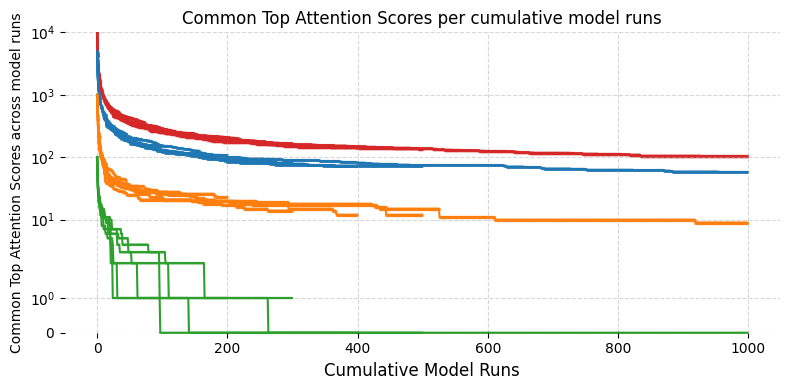

In [365]:
# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4)) # Set figure size for better clarity
###################################################################################################### for 10000 top features

plt.scatter(m100_f10000_p7[1], m100_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m200_f10000_p7[1], m200_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m300_f10000_p7[1], m300_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m400_f10000_p7[1], m400_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m500_f10000_p7[1], m500_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)
plt.scatter(m1000_f10000_p7[1], m1000_f10000_p7[0], color='#d62728', marker='^', s=2, alpha=0.5)

plt.plot(m100_f10000_p7[1], m100_f10000_p7[0], color='#d62728')
plt.plot(m200_f10000_p7[1], m200_f10000_p7[0], color='#d62728')
plt.plot(m300_f10000_p7[1], m300_f10000_p7[0], color='#d62728')
plt.plot(m400_f10000_p7[1], m400_f10000_p7[0], color='#d62728')
plt.plot(m500_f10000_p7[1], m500_f10000_p7[0], color='#d62728')
plt.plot(m1000_f10000_p7[1], m1000_f10000_p7[0], color='#d62728')

###################################################################################################### for 5000 top features

plt.scatter(m100_f5000_p7[1], m100_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m200_f5000_p7[1], m200_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m300_f5000_p7[1], m300_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m400_f5000_p7[1], m400_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m500_f5000_p7[1], m500_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)
plt.scatter(m1000_f5000_p7[1], m1000_f5000_p7[0], color='#1f77b4', marker='*', s=2, alpha=0.5)

plt.plot(m100_f5000_p7[1], m100_f5000_p7[0], color='#1f77b4')
plt.plot(m200_f5000_p7[1], m200_f5000_p7[0], color='#1f77b4')
plt.plot(m300_f5000_p7[1], m300_f5000_p7[0], color='#1f77b4')
plt.plot(m400_f5000_p7[1], m400_f5000_p7[0], color='#1f77b4')
plt.plot(m500_f5000_p7[1], m500_f5000_p7[0], color='#1f77b4')
plt.plot(m1000_f5000_p7[1], m1000_f5000_p7[0], color='#1f77b4')


###################################################################################################### for 1000 top features

plt.scatter(m100_f1000_p7[1], m100_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m200_f1000_p7[1], m200_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m300_f1000_p7[1], m300_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m400_f1000_p7[1], m400_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m500_f1000_p7[1], m500_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)
plt.scatter(m1000_f1000_p7[1], m1000_f1000_p7[0], color='#ff7f0e', marker='o', s=2, alpha=0.5)

plt.plot(m100_f1000_p7[1], m100_f1000_p7[0], color='#ff7f0e')
plt.plot(m200_f1000_p7[1], m200_f1000_p7[0], color='#ff7f0e')
plt.plot(m300_f1000_p7[1], m300_f1000_p7[0], color='#ff7f0e')
plt.plot(m400_f1000_p7[1], m400_f1000_p7[0], color='#ff7f0e')
plt.plot(m500_f1000_p7[1], m500_f1000_p7[0], color='#ff7f0e')
plt.plot(m1000_f1000_p7[1], m1000_f1000_p7[0], color='#ff7f0e')

###################################################################################################### for 100 top features

plt.scatter(m100_f100_p7[1], m100_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m200_f100_p7[1], m200_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m300_f100_p7[1], m300_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m400_f100_p7[1], m400_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m500_f100_p7[1], m500_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)
plt.scatter(m1000_f100_p7[1], m1000_f100_p7[0], color='#2ca02c', marker='+', s=2, alpha=0.5)

plt.plot(m100_f100_p7[1], m100_f100_p7[0], color='#2ca02c')
plt.plot(m200_f100_p7[1], m200_f100_p7[0], color='#2ca02c')
plt.plot(m300_f100_p7[1], m300_f100_p7[0], color='#2ca02c')
plt.plot(m400_f100_p7[1], m400_f100_p7[0], color='#2ca02c')
plt.plot(m500_f100_p7[1], m500_f100_p7[0], color='#2ca02c')
plt.plot(m1000_f100_p7[1], m1000_f100_p7[0], color='#2ca02c')

############################################################################################### 


# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Common Top Attention Scores across model runs', fontsize=10)
plt.title('Common Top Attention Scores per cumulative model runs', fontsize=12, 
          # weight='bold'
         )

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('symlog')
plt.ylim(0,10000)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

## correct color below

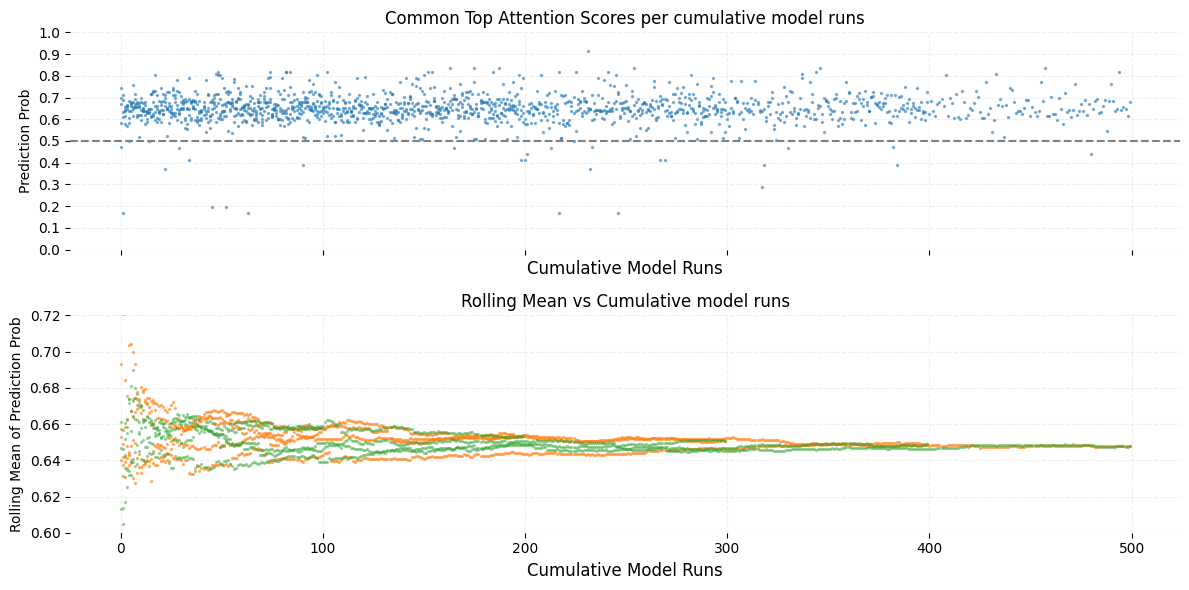

In [348]:
# Create the scatter plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  
###################################################################################################### for 10000 top features
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m100_f10000_p7[1], m100_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m200_f10000_p7[1], m200_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m300_f10000_p7[1], m300_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m400_f10000_p7[1], m400_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[0].scatter(m500_f10000_p7[1], m500_f10000_p7[2], color='#1f77b4', marker='o', s=2, alpha=0.5)


ax[0].axhline(y=0.5, color='gray', linestyle='--')
## Running Mean of prob
###################################################################################################### for 1000 top features
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m100_f1000_p7[1], m100_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m200_f1000_p7[1], m200_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m300_f1000_p7[1], m300_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m400_f1000_p7[1], m400_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m500_f1000_p7[1], m500_f1000_p7[3], color='#ff7f0e', marker='o', s=2, alpha=0.5)


###################################################################################################### for 100 top features
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m100_f100_p7[1], m100_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m200_f100_p7[1], m200_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m300_f100_p7[1], m300_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m400_f100_p7[1], m400_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)
# Scatter plot with custom marker size, edge color, and transparency (alpha)
ax[1].scatter(m500_f100_p7[1], m500_f100_p7[3], color='#2ca02c', marker='x', s=2, alpha=0.5)


# Add grid for better readability
ax[0].grid(True, linestyle='--', alpha=0.2)

# Add labels and title with enhanced font size
ax[0].set_xlabel('Cumulative Model Runs', fontsize=12)
ax[0].set_ylabel('Prediction Prob', fontsize=10)
ax[0].set_title('Common Top Attention Scores per cumulative model runs', fontsize=12, 
          # weight='bold'
         )
# plt.yscale('log')
ax[0].set_ylim(0,1)
yticks = np.arange(0, 1.1, 0.1)  # Generate values from 0 to 1 with a step of 0.1
ax[0].set_yticks(yticks)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
################################################# rolling mean
ax[1].set_xlabel('Cumulative Model Runs', fontsize=12)
ax[1].set_ylabel('Rolling Mean of Prediction Prob', fontsize=10)
ax[1].set_title('Rolling Mean vs Cumulative model runs', fontsize=12, 
          # weight='bold'
         )
ax[1].grid(True, linestyle='--', alpha=0.2)
ax[1].set_ylim(0.6,0.72)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

# Display the plot
plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

### for all patients

In [369]:
adverse_list = adverse_indices.numpy().tolist()

In [383]:
# list100  = []
# list1000 = []
# list10000= []

# for i in tqdm(adverse_list):
#     list100.append(cudrop(1000, 100, i))
#     list1000.append(cudrop(1000, 1000, i))
#     list10000.append(cudrop(1000, 10000, i))

In [374]:
import pickle

In [387]:
# List comprehension to separate even and odd index elements
list1k_temp = [list1000[i] for i in range(len(list1000)) if i % 2 == 0]  # Elements at even indices
list10k_temp = [list1000[i] for i in range(len(list1000)) if i % 2 != 0]   # Elements at odd indices

In [436]:
list1k = list1k_temp
list10k = list10k_temp

In [437]:
len(list100), len(list1k), len(list10k)

(186, 186, 186)

In [391]:
# # Save the list to a pickle file
# with open('cudrop_1000m_100f.pkl', 'wb') as file:  # Open file in binary write mode
#     pickle.dump(list100, file)
    
# # Save the list to a pickle file
# with open('cudrop_1000m_1000f.pkl', 'wb') as file:  # Open file in binary write mode
#     pickle.dump(list1k_temp, file)
    
# # Save the list to a pickle file
# with open('cudrop_1000m_10000f.pkl', 'wb') as file:  # Open file in binary write mode
#     pickle.dump(lis10k_temp, file)

In [443]:
list100_mean     = np.mean(np.array([item[0] for item  in list100]),axis=0).tolist()
list1k_mean      = np.mean(np.array([item[0] for item  in list1k_temp]),axis=0).tolist()
list10k_mean    = np.mean(np.array([item[0] for item  in list10k_temp]),axis=0).tolist()

In [445]:
len(list100_mean), len(list1k_mean), len(list10k_mean)

(1000, 1000, 1000)

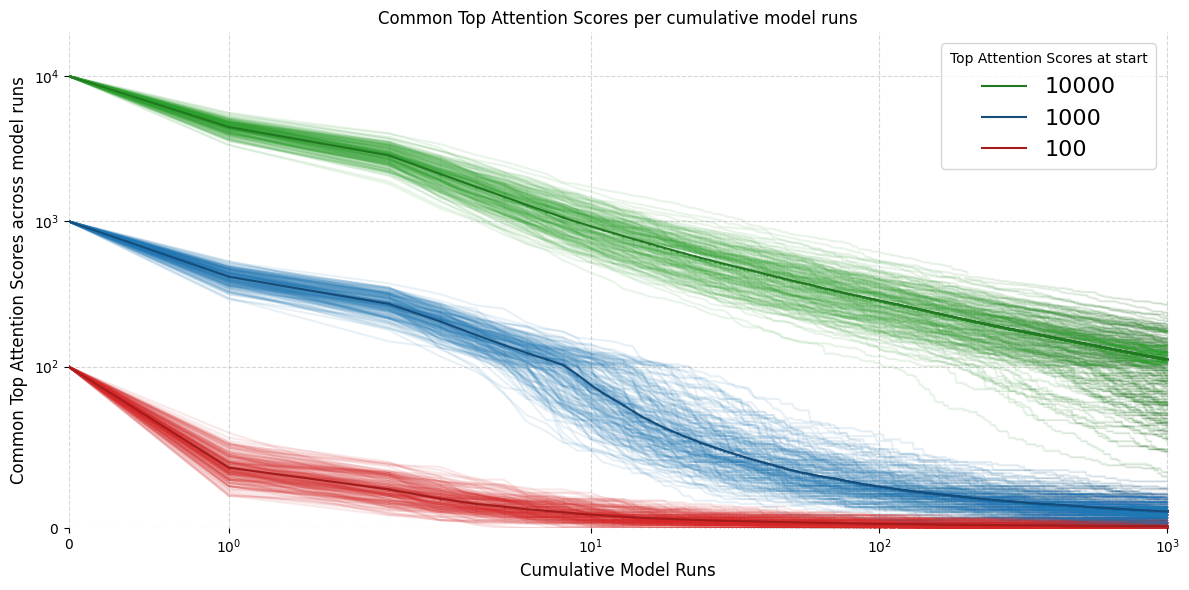

In [605]:
# Create the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # Set figure size for better clarity
###################################################################################################### for 10000 top features


for item in list100:
    plt.scatter(item[1], item[0], color='#d62728', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#d62728',alpha=0.1)
    

for item in list1k:
    plt.scatter(item[1], item[0], color='#1f77b4', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#1f77b4',alpha=0.1)
    
    
for item in list10k:
    plt.scatter(item[1], item[0], color='#2ca02c', marker='o', s=1, alpha=0.005)
    plt.plot(item[1], item[0], color='#2ca02c',alpha=0.1)    

############################################################################################### 

plt.scatter(list(range(len(list100_mean))), list100_mean, color='#a31c1c', marker='.', s=2, alpha=1.0)
plt.plot(list(range(len(list100_mean))), list100_mean, color='#a31c1c',alpha=1.0, label='100')

plt.scatter(list(range(len(list1k_mean))), list1k_mean, color='#154c7a', marker='.', s=2, alpha=1.0)
plt.plot(list(range(len(list1k_mean))), list1k_mean, color='#154c7a',alpha=1.0, label='1000')

plt.scatter(list(range(len(list10k_mean))), list10k_mean, color='#217821', marker='.', s=2, alpha=1.0)
plt.plot( list(range(len(list10k_mean))), list10k_mean, color='#217821',alpha=1.0,label='10000')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add labels and title with enhanced font size
plt.xlabel('Cumulative Model Runs', fontsize=12)
plt.ylabel('Common Top Attention Scores across model runs', fontsize=12)
plt.title('Common Top Attention Scores per cumulative model runs', fontsize=12, 
          # weight='bold'
         )

# Enhance ticks for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yscale('symlog', 
           linthresh=100
          )
# plt.yscale('asinh', linthresh=10)
plt.xscale('symlog', 
           # linthresh=10
          )
# plt.xscale('asinh')

plt.ylim(0,20000)
plt.xlim(0,1001)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# Display the plot
# Reversing the order of the legend items
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper right', fontsize=16, title='Top Attention Scores at start')  # Reversing handles and labels

plt.tight_layout()  # Adjust layout to make sure everything fits nicely
plt.show()

In [521]:
### scatter for probabiility -- this doesn't work

In [516]:
# # Create the scatter plot
# fig, ax = plt.subplots(1, 1, figsize=(12, 6)) # Set figure size for better clarity
# ###################################################################################################### for 10000 top features


# # for item in list100:
# #     plt.scatter(item[1], item[2], color='#d62728', marker='o', s=1, alpha=0.1)
# #     # plt.plot(item[1], item[2], color='#d62728',alpha=0.1)
    

# # for item in list1k:
# #     plt.scatter(item[1], item[2], color='#1f77b4', marker='o', s=1, alpha=0.1)
# #     # plt.plot(item[1], item[2], color='#1f77b4',alpha=0.1)
    
    
# for item in list10k:
#     plt.scatter(item[1], item[3], color='#ff7f0e', marker='o', s=1, alpha=0.1)
#     # plt.plot(item[1], item[2], color='#ff7f0e',alpha=0.1)    

# ############################################################################################### 

# # Add grid for better readability
# plt.grid(True, linestyle='--', alpha=0.5)

# # Add labels and title with enhanced font size
# plt.xlabel('Cumulative Model Runs', fontsize=12)
# plt.ylabel('Common Top Attention Scores across model runs', fontsize=16)
# plt.title('Common Top Attention Scores per cumulative model runs', fontsize=12, 
#           # weight='bold'
#          )

# # Enhance ticks for better readability
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# # plt.yscale('symlog')
# # plt.xscale('log')
# # plt.ylim(0,10000)
# # plt.xlim(0,1000)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# # Display the plot
# plt.tight_layout()  # Adjust layout to make sure everything fits nicely
# plt.show()

### get the highest drop pattern in 10000

In [527]:
l10kl = np.array([item[0] for item  in list10k_temp])

In [528]:
l10kl.shape

(186, 1000)